In [1]:
from scipy.constants import Planck, gas_constant, Boltzmann
import numpy as np
import matplotlib.pyplot as plt
from model import extract_thermodynamic_parameters, calculate_gibbs, eyring_rate, simulate_dna_melting

In [2]:
dna_sequence = "GATTACA"

deltaH, deltaS = extract_thermodynamic_parameters(dna_sequence)

print(f"Total delta H: {deltaH} cal/mol")
print(f"Total delta S: {deltaS} cal/mol.K")

Total delta H: 47400.0 cal/mol
Total delta S: 131.2 cal/mol.K


In [3]:
temperature_range = np.linspace(0 + 273, 80 + 273, 81)
temperature_range

array([273., 274., 275., 276., 277., 278., 279., 280., 281., 282., 283.,
       284., 285., 286., 287., 288., 289., 290., 291., 292., 293., 294.,
       295., 296., 297., 298., 299., 300., 301., 302., 303., 304., 305.,
       306., 307., 308., 309., 310., 311., 312., 313., 314., 315., 316.,
       317., 318., 319., 320., 321., 322., 323., 324., 325., 326., 327.,
       328., 329., 330., 331., 332., 333., 334., 335., 336., 337., 338.,
       339., 340., 341., 342., 343., 344., 345., 346., 347., 348., 349.,
       350., 351., 352., 353.])

In [4]:
k = []
g = []
for _, j in enumerate(temperature_range):
    gibbs_ = calculate_gibbs(
    enthalpy = deltaH,
    entropy = deltaS,
    temperature = j
                        )
    g.append(gibbs_)
    k_ = eyring_rate(j, gibbs_, kappa=1)
    k.append(k_)

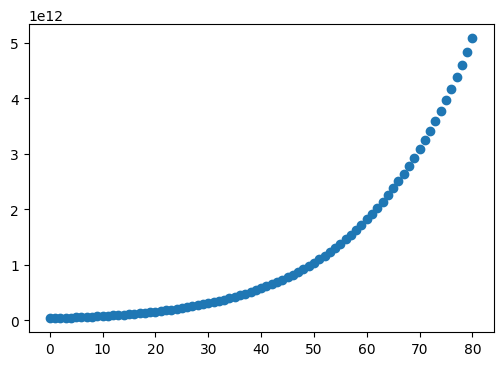

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.scatter(temperature_range - 273, k)

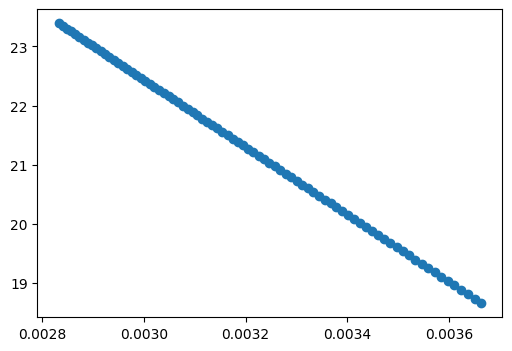

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(6,4))
ax.scatter(1 / temperature_range, np.log(k / temperature_range))

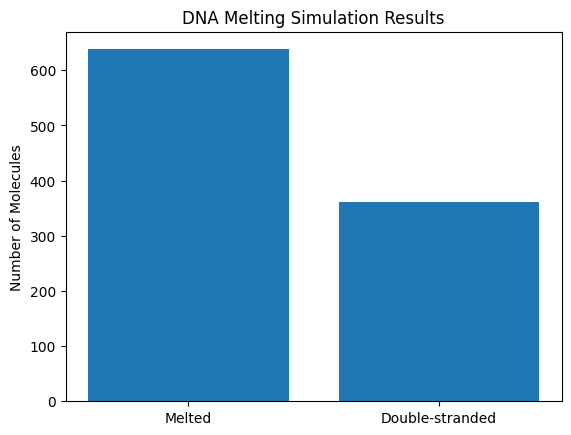

In [13]:
# Parameters
num_molecules = 1000
rate_constant = 0.001  # Example rate constant, adjust based on your model
num_steps = 1000

# Run simulation
final_states = simulate_dna_melting(num_molecules, rate_constant, num_steps)

# Calculate and print the fraction of melted DNA
fraction_double = np.sum(final_states) / num_molecules

# Plotting (optional)
plt.hist(final_states, bins=[0, 1, 2], rwidth=0.8)
plt.xticks([0.5, 1.5], ['Melted', 'Double-stranded'])
plt.ylabel('Number of Molecules')
plt.title('DNA Melting Simulation Results')
plt.show()
